# Image Segmentation using U-Net

-  Designed for Semantic Segmentation for MRI Images.

- Consider two blocks or path in the netweork architecture : Contraction and Expansion

- Semantic Segmentation : Paint the pixels corresponding to the object of interest in the image.

- Instance Segmentation: Extensionof semantic segmentation where we separate each individual of the painted pixels.

- Contraction path is also called Encoder Path
- Expansion path is also called Decoder Path

- Concatenation of feature maps helps give loalization Information.

### Building U-Net Model

- Original Model takes image in size 572 x 572 but we can modify it.

[]('images/u-net-architecture.png')


In [1]:
import tensorflow as tf


IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)  #dropout 10% nides from layer c1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

`kernel_initializer` assign the initial weights to the nodes of Neural Network. 'he_normal' is a truncated normal distribution centered around 0. 

### Image Segmentation example: Nuclei Segmentation

**Dataset:** Kaggle :- 2018 Data Science Bowl (Stage1_test and Stage1_train)

NOTE: If you observe the 'masks' directory. Instead of one image of all the painted (masked) pixels, we have different images and each image showing one single cell that's actually labelled. So we have to do some extra work to put all of these masks together to create one mask that has all of these pixels.


In [6]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm     # shows the progress bar during loop execution

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed


#resizing all of the image sto 128 x 128

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'images/stage1_train/'
TEST_PATH = 'images/stage1_test/'

#reading all the image IDs which are nothing but the folder name of each image
train_ids = next(os.walk(TRAIN_PATH))[1]  #`next` returns the next item in the iterator
test_ids = next(os.walk(TEST_PATH))[1]

###################################################################################################
#   since we only only need the list of sub-folders and not the name of main folder intacted,     #
#   we specify [1] i.e., only having 2nd value of the tuple created as 'train_ids'.               #
###################################################################################################


#creating an empty array of the same dimesion of the images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
              
        mask = np.maximum(mask, mask_)  
    #iterating through each image in the 'masks' folder and at a given pixel we are taking the max value.
        
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


  3%|▎         | 2/65 [00:00<00:03, 16.74it/s]

Resizing test images


100%|██████████| 65/65 [00:03<00:00, 21.65it/s]

Done!


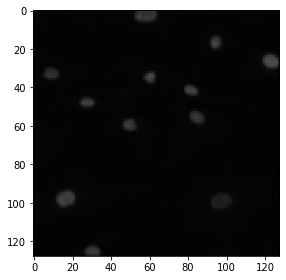

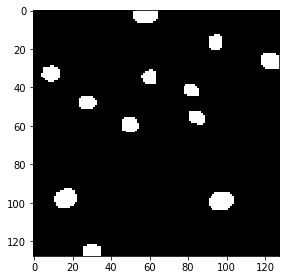

In [7]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [ ]:
# #Build the model
# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# #Contraction path
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = tf.keras.layers.Dropout(0.1)(c1)
# c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
# p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)
# c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
# p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.2)(c3)
# c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
# p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4)
# c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
# p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.3)(c5)
# c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# #Expansive path 
# u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
# u6 = tf.keras.layers.concatenate([u6, c4])
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = tf.keras.layers.Dropout(0.2)(c6)
# c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
# u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
# u7 = tf.keras.layers.concatenate([u7, c3])
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = tf.keras.layers.Dropout(0.2)(c7)
# c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
# u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
# u8 = tf.keras.layers.concatenate([u8, c2])
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.1)(c8)
# c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
# u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
# u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.1)(c9)
# c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
# outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
# model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

**`ModelCheckpoint()` :** Training a NN can take a lot of time even few days. So if something unexpected happens inbetween the training, you don't want to loose all that process which has been till then,

Checkpoints are like timestamps. You can save your model when something happens or an event which we have defined as a checkpoint occurs.

Arguments of `ModelCheckpoint()`:

- `filepath`: string, path to save the model file.

- `monitor`: quantity to monitor.

- `save_best_only`: if `save_best_only=True`, the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.

**Callbacks:** utilities called at certain points during model training.

- `tf.keras.callbacks.Callback()`: There is risk of overfitting if the number of epoch is large also if there are too less epochs then undefitting may occur.So we never know what is the exact suitable number of epoch. This is when early stopping can be really useful. You can pick a value to be monitored for e.g. 'validation loss' and then if there is no improvement in the value under monitor go ahead and stop it. The `patience` allows not to stop immediately but watch till the provided `patience` value. 

- `tf.keras.callbacks.TensorBoard()`:This callback ensures that logs are created and stored. Additionally, enable histogram computation every epoch with histogram_freq=1 (this is off by default).

In [8]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

####################################

Train on 603 samples, validate on 67 samples
Epoch 1/25
603/603 [==============================] - 93s 155ms/sample - loss: 0.5332 - accuracy: 0.8000 - val_loss: 0.3418 - val_accuracy: 0.8466
Epoch 2/25
603/603 [==============================] - 86s 143ms/sample - loss: 0.2709 - accuracy: 0.8719 - val_loss: 0.1987 - val_accuracy: 0.9245
Epoch 3/25
603/603 [==============================] - 87s 144ms/sample - loss: 0.1643 - accuracy: 0.9365 - val_loss: 0.1496 - val_accuracy: 0.9479
Epoch 4/25
603/603 [==============================] - 87s 143ms/sample - loss: 0.1335 - accuracy: 0.9477 - val_loss: 0.1067 - val_accuracy: 0.9596
Epoch 5/25
603/603 [==============================] - 86s 143ms/sample - loss: 0.1240 - accuracy: 0.9512 - val_loss: 0.1119 - val_accuracy: 0.9581
Epoch 6/25
603/603 [==============================] - 86s 143ms/sample - loss: 0.1164 - accuracy: 0.9547 - val_loss: 0.0879 - val_accuracy: 0.9682
Epoch 7/25
603/603 [==============================] - 89s 147ms/sample - 

In [9]:
idx = random.randint(0, len(X_train))  #randomly picking any image


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

#making the prediction binary as the prediction will be in terms of probability 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

65/65 [==============================] - 1s 23ms/sample


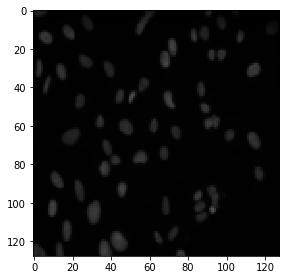

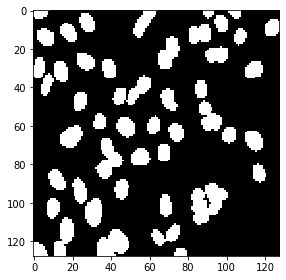

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


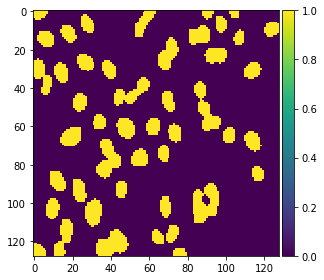

In [10]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

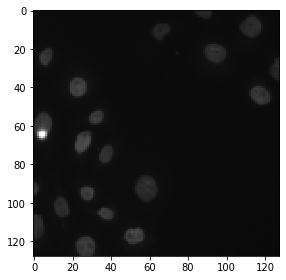

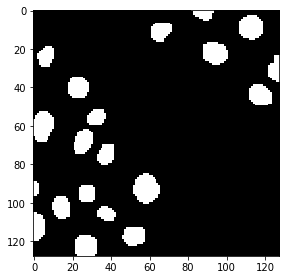

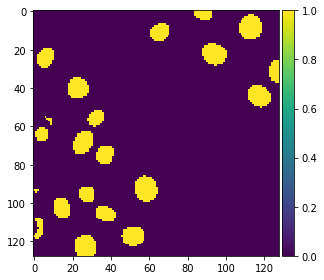

In [11]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

### 